In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import regex as re
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_validate, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, make_scorer, f1_score
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.loc[df.review.isna()]  # 0 NaN values

,review,sentiment


In [4]:
df.loc[0,'review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [5]:
df['review'] = df.review.str.replace(r'<br /><br />', ' ')  # replace <br /><br /> with a whitespace

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = Counter(stopwords.words('english'))  # faster look-up if dictionary
del stop_words['no']  # remove 'no' and 'not' from stopwords
del stop_words['not']

def review_cleaner(review, stop_words):
    review = re.sub(r"[^a-zA-Z]", " ", review)
    review = re.sub(r'\s+', ' ', review, flags=re.I)  # flags to ignore case
    reduced_review = [word for word in review.lower().split() if word not in stop_words]
    lem_review = [lemmatizer.lemmatize(word) for word in reduced_review if len(lemmatizer.lemmatize(word)) > 1]
    return ' '.join(lem_review)

In [7]:
df['review'] = df.review.apply(lambda x: review_cleaner(x, stop_words))

In [8]:
df.loc[0, 'review']  # preview of a cleaned review

'one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust not show faint hearted timid show pull no punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy not high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence not violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experienc

In [9]:
df.sentiment.replace({'positive': 1, 'negative': 0}, inplace=True)
df.head()

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1


#### Dataset Exploration

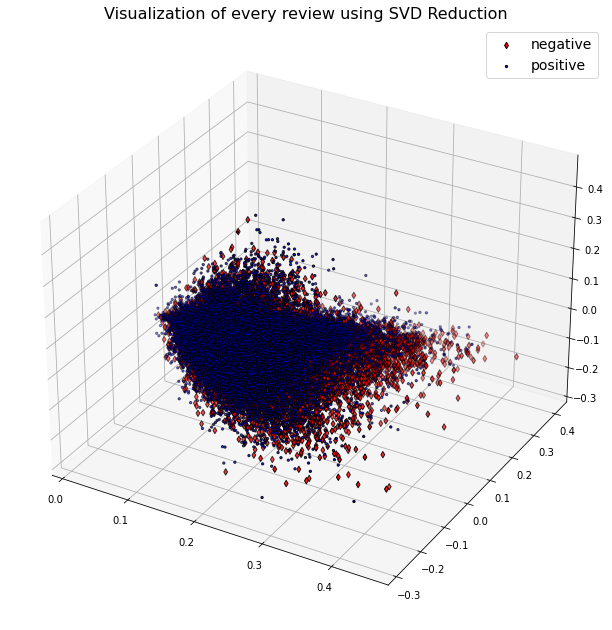

In [10]:
X_Total = TfidfVectorizer().fit_transform(df.review.tolist())  # tfidf the whole dataset
svd = TruncatedSVD(n_components=3)  # Svd and only keep three columns
svd_x = svd.fit_transform(X_Total)

fig = plt.figure(figsize=(11,11))
fig.patch.set_alpha(1)

ax= fig.add_subplot(111, projection='3d')
ax.scatter(svd_x[df.sentiment.to_numpy()==0,0], svd_x[df.sentiment.to_numpy()==0 ,1], svd_x[df.sentiment.to_numpy()==0,2], 
            c='r', edgecolor='k', marker='d', label='negative')
ax.scatter(svd_x[df.sentiment.to_numpy()==1,0], svd_x[df.sentiment.to_numpy()==1 ,1], svd_x[df.sentiment.to_numpy()==1,2], 
            c='b', edgecolor='k', marker='.', label='positive')
ax.set_title('Visualization of every review using SVD Reduction', fontsize=16)
ax.legend(fontsize=14)

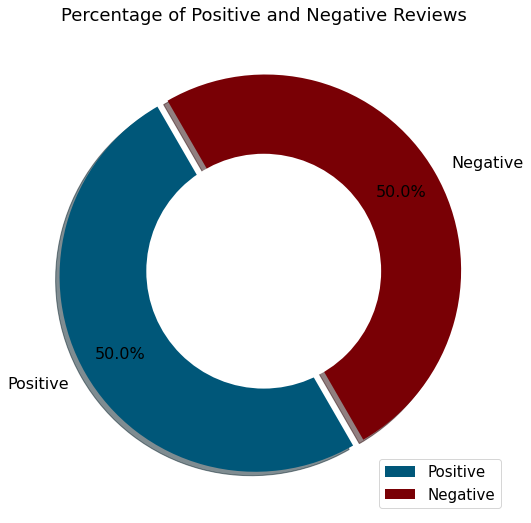

In [11]:
fig = plt.figure(figsize=(10,9))
fig.patch.set_alpha(1)
ax = fig.add_subplot(111)

labels = ['Positive', 'Negative']
colors = ['#005779', '#790005']
ax.pie(df.sentiment.value_counts().tolist(), colors=colors, autopct='%.1f%%', labels=labels,
        pctdistance=0.8, textprops={'fontsize': 16}, startangle=120, shadow=0.9, explode=(0.05,0.01))
ax.legend(labels, loc='lower right', fontsize=15)
ax.set_title('Percentage of Positive and Negative Reviews', fontsize=18)

centre_circle = plt.Circle((0,0),0.60,fc='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)

In [12]:
vocab_size = len(set([word for sent in df.review.tolist() for word in sent.split()]))
print(f'The dataset contains {len(df.review.tolist())} reviews and {vocab_size} unique words (after cleaning).')

n_words = [len(sent.split()) for sent in df.review.tolist()]
avg_review_len = np.mean(n_words)
std_review_len = np.std(n_words)
print(f'The average number of words in a review is {round(avg_review_len)} with a standard deviation of {round(std_review_len)}')

The dataset contains 50000 reviews and 89734 unique words (after cleaning).
The average number of words in a review is 119 with a standard deviation of 90


#### Modeling

For each machine learning algorithm, a pipeline was created and using RandomizedSearchCV() the hyperparameters of the processing steps and models were tuned. The processing steps include a TF-IDF vectorization and a feature selection using chi-squared.

In [13]:
X = df.review.tolist()
y = df.sentiment.tolist()

assert len(X) == len(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
cv = KFold(n_splits=3, shuffle=True, random_state=42)  # for time efficiency, the number of splits were chosen to be 3

scoring = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'accuracy': make_scorer(accuracy_score),
    }

#### Logistic Regression

In [24]:
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('kbest', SelectKBest(score_func=chi2)),
    ('lr', LogisticRegression(max_iter=10000))])

params = [{
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],  
    'tfidf__sublinear_tf': [True, False],
    'kbest__k': [2000, 2500, 3000, 3500, 4000, 5000],
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['lbfgs', 'sag', 'saga', 'liblinear']
}]

lr_best_params = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=params,
    n_iter=100,
    n_jobs=4,
    cv=cv
)

lr_best_params.fit(X_train, y_train)
print(lr_best_params.best_params_)

C:\Users\steli\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
84 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\steli\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\steli\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\steli\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty,

{'tfidf__sublinear_tf': True, 'tfidf__ngram_range': (1, 1), 'lr__solver': 'saga', 'lr__penalty': 'l2', 'kbest__k': 5000}


In [15]:
lr = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, ngram_range=(1,1))),
    ('kbest', SelectKBest(score_func=chi2, k=5000)),
    ('lr', LogisticRegression(max_iter=10000, penalty='l2', solver='saga'))
])

lr_scores = cross_validate(estimator=lr , X=X_train, y=y_train, cv=cv, scoring=scoring)
lr_scores

{'fit_time': array([3.2349236 , 3.14665556, 3.17822361]),
 'score_time': array([1.42445111, 1.32715368, 1.35766935]),
 'test_f1_macro': array([0.88764215, 0.88095081, 0.88604112]),
 'test_accuracy': array([0.88765562, 0.88097202, 0.88607215])}

#### Decision Tree

In [28]:
tree_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('kbest', SelectKBest(score_func=chi2)),
    ('tree', DecisionTreeClassifier())
])

params = [{
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)],  
    'tfidf__sublinear_tf': [True,False],
    'kbest__k': [2000,2500,3000,3500,4000,5000],
    'tree__criterion': ['gini', 'entropy'],
    'tree__splitter': ['best', 'random'],
    'tree__max_depth': [2,3,4,6,8,10,15,20,25,40,55,67,70,None],
}]

tree_params = RandomizedSearchCV(
    estimator=tree_pipeline,
    param_distributions=params,
    n_iter=100,
    cv=cv,
    n_jobs=4
)

tree_params.fit(X_train, y_train)
print(tree_params.best_params_)

{'tree__splitter': 'random', 'tree__max_depth': 20, 'tree__criterion': 'gini', 'tfidf__sublinear_tf': False, 'tfidf__ngram_range': (1, 1), 'kbest__k': 2000}


In [16]:
tree = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,1), sublinear_tf=False)),
    ('kbest', SelectKBest(k=2000)),
    ('tree', DecisionTreeClassifier(criterion='gini', max_depth=20, splitter='random'))
])

tree_scores = cross_validate(tree, X_train, y_train, scoring=scoring, cv=cv)
tree_scores

{'fit_time': array([6.10974026, 5.24960256, 5.40491104]),
 'score_time': array([1.28695226, 1.28909421, 1.30187869]),
 'test_f1_macro': array([0.74081156, 0.73115997, 0.7344459 ]),
 'test_accuracy': array([0.7419379 , 0.73261832, 0.73659341])}

#### Adaptive Boosting Trees

In [29]:
ada_tree_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('kbest', SelectKBest(score_func=chi2)),
    ('ada_tree', AdaBoostClassifier(base_estimator= DecisionTreeClassifier(criterion='gini', splitter='best')))
])

params = [{
    'kbest__k': [2000, 2500, 3000, 3500],
    'ada_tree__n_estimators': [500, 600, 700, 800, 1000],
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)],  
    'tfidf__sublinear_tf': [True,False],
    'ada_tree__learning_rate': [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}]

ada_tree_params = RandomizedSearchCV(
    ada_tree_pipeline,
    n_iter=100, 
    param_distributions=params, 
    cv=cv, 
    n_jobs=4)

ada_tree_params.fit(X_train, y_train)
print(ada_tree_params.best_params_)

{'tfidf__sublinear_tf': False, 'tfidf__ngram_range': (1, 1), 'kbest__k': 2000, 'ada_tree__n_estimators': 500, 'ada_tree__learning_rate': 0.9}


In [17]:
ada = AdaBoostClassifier(
    base_estimator= DecisionTreeClassifier(criterion='gini', max_depth=1, splitter='random'),
    n_estimators=500,
    learning_rate=0.9,
    algorithm='SAMME.R'
)

ada_tree = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=False, ngram_range=(1,1))),
    ('kbest', SelectKBest(score_func=chi2, k=2000)),
    ('ada', ada)
])

ada_scores = cross_validate(ada_tree, X_train, y_train, scoring=scoring, cv=cv)
ada_scores

{'fit_time': array([19.93615961, 20.08062458, 20.08970833]),
 'score_time': array([3.0281601 , 3.05467963, 3.11553121]),
 'test_f1_macro': array([0.85225004, 0.85523523, 0.86256656]),
 'test_accuracy': array([0.85225739, 0.85524638, 0.86259656])}

#### Random Forest

In [33]:
forest_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('kbest', SelectKBest(chi2)),
    ('forest', RandomForestClassifier())
])

params = [{
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)],  
    'tfidf__sublinear_tf': [True, False],
    'kbest__k': [2000, 2500, 3000, 3500, 5000],
    'forest__criterion': ['gini', 'entropy'],
    'forest__max_depth': [12, 15, 20, 30, 40],
    'forest__min_samples_split': [2, 5, 10],
    'forest__min_samples_leaf': [1, 2, 4],
    'forest__bootstrap': [True, False],
    'forest__n_estimators': [600, 800, 1000]
}]

forest_params = RandomizedSearchCV(
    estimator=forest_pipeline,
    param_distributions=params,
    n_iter=100,
    cv=cv,
    n_jobs=4
)

forest_params.fit(X_train, y_train)
print(forest_params.best_params_)

{'tfidf__sublinear_tf': False, 'tfidf__ngram_range': (1, 2), 'kbest__k': 5000, 'forest__n_estimators': 1000, 'forest__min_samples_split': 5, 'forest__min_samples_leaf': 2, 'forest__max_depth': 40, 'forest__criterion': 'entropy', 'forest__bootstrap': True}


In [18]:
forest = RandomForestClassifier(
    n_estimators=1000,
    min_samples_split=5,
    max_depth=40,
    criterion='entropy',
    min_samples_leaf=2,
    bootstrap=True
)

forest_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=False, ngram_range=(1,2))),
    ('kbest', SelectKBest(score_func=chi2, k=5000)),
    ('forest', forest)
])

forest_scores = cross_validate(forest_pipe, X_train, y_train, scoring=scoring, cv=cv)
forest_scores

{'fit_time': array([165.82782149, 166.78056574, 165.8535111 ]),
 'score_time': array([6.83170557, 7.06183624, 7.02843952]),
 'test_f1_macro': array([0.84646502, 0.8443446 , 0.85609294]),
 'test_accuracy': array([0.84648268, 0.84437111, 0.8561464 ])}

#### KNN

In [39]:
knn_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('kbest', SelectKBest(chi2)),
    ('knn', KNeighborsClassifier())
])

params = [{
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)],  
    'tfidf__sublinear_tf': [True,False],
    'kbest__k': [2000,2500,3000,3500],
    'knn__n_neighbors': [7, 9, 11, 15, 17],
    'knn__weights': ['uniform', 'distance']
}]

knn_params = RandomizedSearchCV(
    estimator=knn_pipeline,
    param_distributions=params,
    n_iter=100,
    cv=cv,
    n_jobs=4
)

knn_params.fit(X_train, y_train)
print(knn_params.best_params_)


{'tfidf__sublinear_tf': False, 'tfidf__ngram_range': (1, 3), 'knn__weights': 'distance', 'knn__n_neighbors': 17, 'kbest__k': 2000}


In [19]:
knn = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), sublinear_tf=False)),
    ('kbest', SelectKBest(score_func=chi2, k=2000)),
    ('knn', KNeighborsClassifier(weights='distance', n_neighbors=17))])

knn_scores = cross_validate(knn, X_train, y_train, scoring=scoring, cv=cv)
knn_scores

{'fit_time': array([32.87801361, 33.25020289, 32.89080262]),
 'score_time': array([22.05154014, 22.01966405, 20.61353707]),
 'test_f1_macro': array([0.71233209, 0.73446679, 0.71334999]),
 'test_accuracy': array([0.72378881, 0.73801845, 0.72436811])}

#### Naive Bayes

In [35]:
# Multinomial Naive Bayes
m_nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('kbest', SelectKBest(chi2)),
    ('nb', MultinomialNB())
])

params = [{
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)],  
    'kbest__k': [4000, 5000, 7000, 8000, 9000, 10000],
    'nb__alpha': list(np.arange(0.1,1.01,0.01))
}]

m_nb_params = RandomizedSearchCV(
    estimator=m_nb_pipeline,
    param_distributions=params,
    n_iter=100,
    cv=cv,
    n_jobs=4
)

m_nb_params.fit(X_train, y_train)
print(m_nb_params.best_params_)

{'tfidf__ngram_range': (1, 3), 'nb__alpha': 0.18999999999999995, 'kbest__k': 9000}


In [20]:
m_nb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3))),
    ('kbest', SelectKBest(score_func=chi2, k=9000)),
    ('nb', MultinomialNB(alpha=0.19))])

mnb_scores = cross_validate(m_nb, X_train, y_train, scoring=scoring, cv=cv)
mnb_scores

{'fit_time': array([33.16841984, 32.89636111, 32.78639913]),
 'score_time': array([6.25364661, 6.27322054, 6.30423713]),
 'test_f1_macro': array([0.88064389, 0.88296664, 0.87981338]),
 'test_accuracy': array([0.88068097, 0.88299707, 0.879847  ])}

#### SVM

In [40]:
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('kbest', SelectKBest(chi2)),
    ('svm', SVC())
])

params = [{
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],  
    'tfidf__sublinear_tf': [True, False],
    'kbest__k': [2000, 3000, 4000,5000],
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__gamma': [0.01, 0.1, 1, 2, 3]
}]

svm_params = RandomizedSearchCV(
    estimator=svm_pipeline,
    param_distributions=params,
    n_iter=100,
    cv=cv,
    n_jobs=4
)

svm_params.fit(X_train, y_train)
print(svm_params.best_params_)

{'tfidf__sublinear_tf': True, 'tfidf__ngram_range': (1, 2), 'svm__kernel': 'linear', 'svm__gamma': 0.01, 'svm__C': 10, 'kbest__k': 5000}


In [21]:
svm = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True)),
    ('kbest', SelectKBest(score_func=chi2, k=5000)),
    ('svm', SVC(C=10, kernel='linear', gamma=0.01, probability=True))])

svm_scores = cross_validate(svm, X_train, y_train, scoring=scoring, cv=cv)
svm_scores

{'fit_time': array([566.38234425, 560.96068382, 591.06343246]),
 'score_time': array([42.42234993, 41.95721221, 43.88934541]),
 'test_f1_macro': array([0.89702424, 0.89243388, 0.89932595]),
 'test_accuracy': array([0.89703015, 0.89244731, 0.89934748])}

#### XGBoost

In [37]:
xgb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('kbest', SelectKBest(chi2)),
    ('xgb', XGBClassifier(use_label_encoder=False))
])

params = [{
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],  
    'tfidf__sublinear_tf': [True, False],
    'kbest__k': [2000, 3000, 4000, 5000],
    'xgb__n_estimators': [900, 1000],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
    'xgb__gamma': [0.5, 1, 2, 3, 5, 10],
    'xgb__max_depth': [4, 5, 6],
    'xgb__colsample_bytree': [0.3, 0.6, 0.8],
    'xgb__subsample': [0.6, 0.7, 1.0],
    'xgb__min_child_weight': [4, 5, 6, 7, 10],
    'xgb__reg_alpha': [0, 0.5, 1],
    'xgb__reg_lambda': [1, 1.5, 2, 3]
}]

xgb_params = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=params,
    n_iter=100,
    cv=cv,
    n_jobs=4
)

xgb_params.fit(X_train, y_train)
print(xgb_params.best_params_)

[00:29:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'xgb__subsample': 0.6, 'xgb__reg_lambda': 2, 'xgb__reg_alpha': 0.5, 'xgb__n_estimators': 900, 'xgb__min_child_weight': 4, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 5, 'xgb__colsample_bytree': 0.8, 'tfidf__sublinear_tf': False, 'tfidf__ngram_range': (1, 2), 'kbest__k': 5000}


In [22]:
xgb_cl = XGBClassifier(
    subsample=0.6,
    reg_lambda=2,
    reg_alpha=0.5,
    n_estimators=900,
    min_child_weight=4,
    max_depth=6,
    learning_rate=0.1,
    gamma=5,
    colsample_bytree=0.8,
    use_label_encoder=False,
    
)

xgb = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=False, ngram_range=(1,2))),
    ('kbest', SelectKBest(score_func=chi2, k=5000)),
    ('xgb', xgb_cl)
])

xgb_scores = cross_validate(xgb, X_train, y_train, scoring=scoring, cv=cv)
xgb_scores

[11:40:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:42:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'fit_time': array([45.85734153, 56.52820277, 57.02155232]),
 'score_time': array([4.06762338, 4.00645065, 4.14173627]),
 'test_f1_macro': array([0.87564836, 0.87009096, 0.87779765]),
 'test_accuracy': array([0.87565622, 0.87009675, 0.87782195])}

#### Learning curves

In [23]:
total_models = [
    (lr, 'Logistic Regression'),
    (tree, 'Decision Tree'),
    (ada_tree, 'Adaptive Boosting Trees'),
    (forest_pipe, 'Random Forest'),
    (knn, 'KNN'),
    (m_nb, 'Multinomial Naive Bayes'),
    (svm, 'SVM'),
    (xgb, 'XGBoost')
]

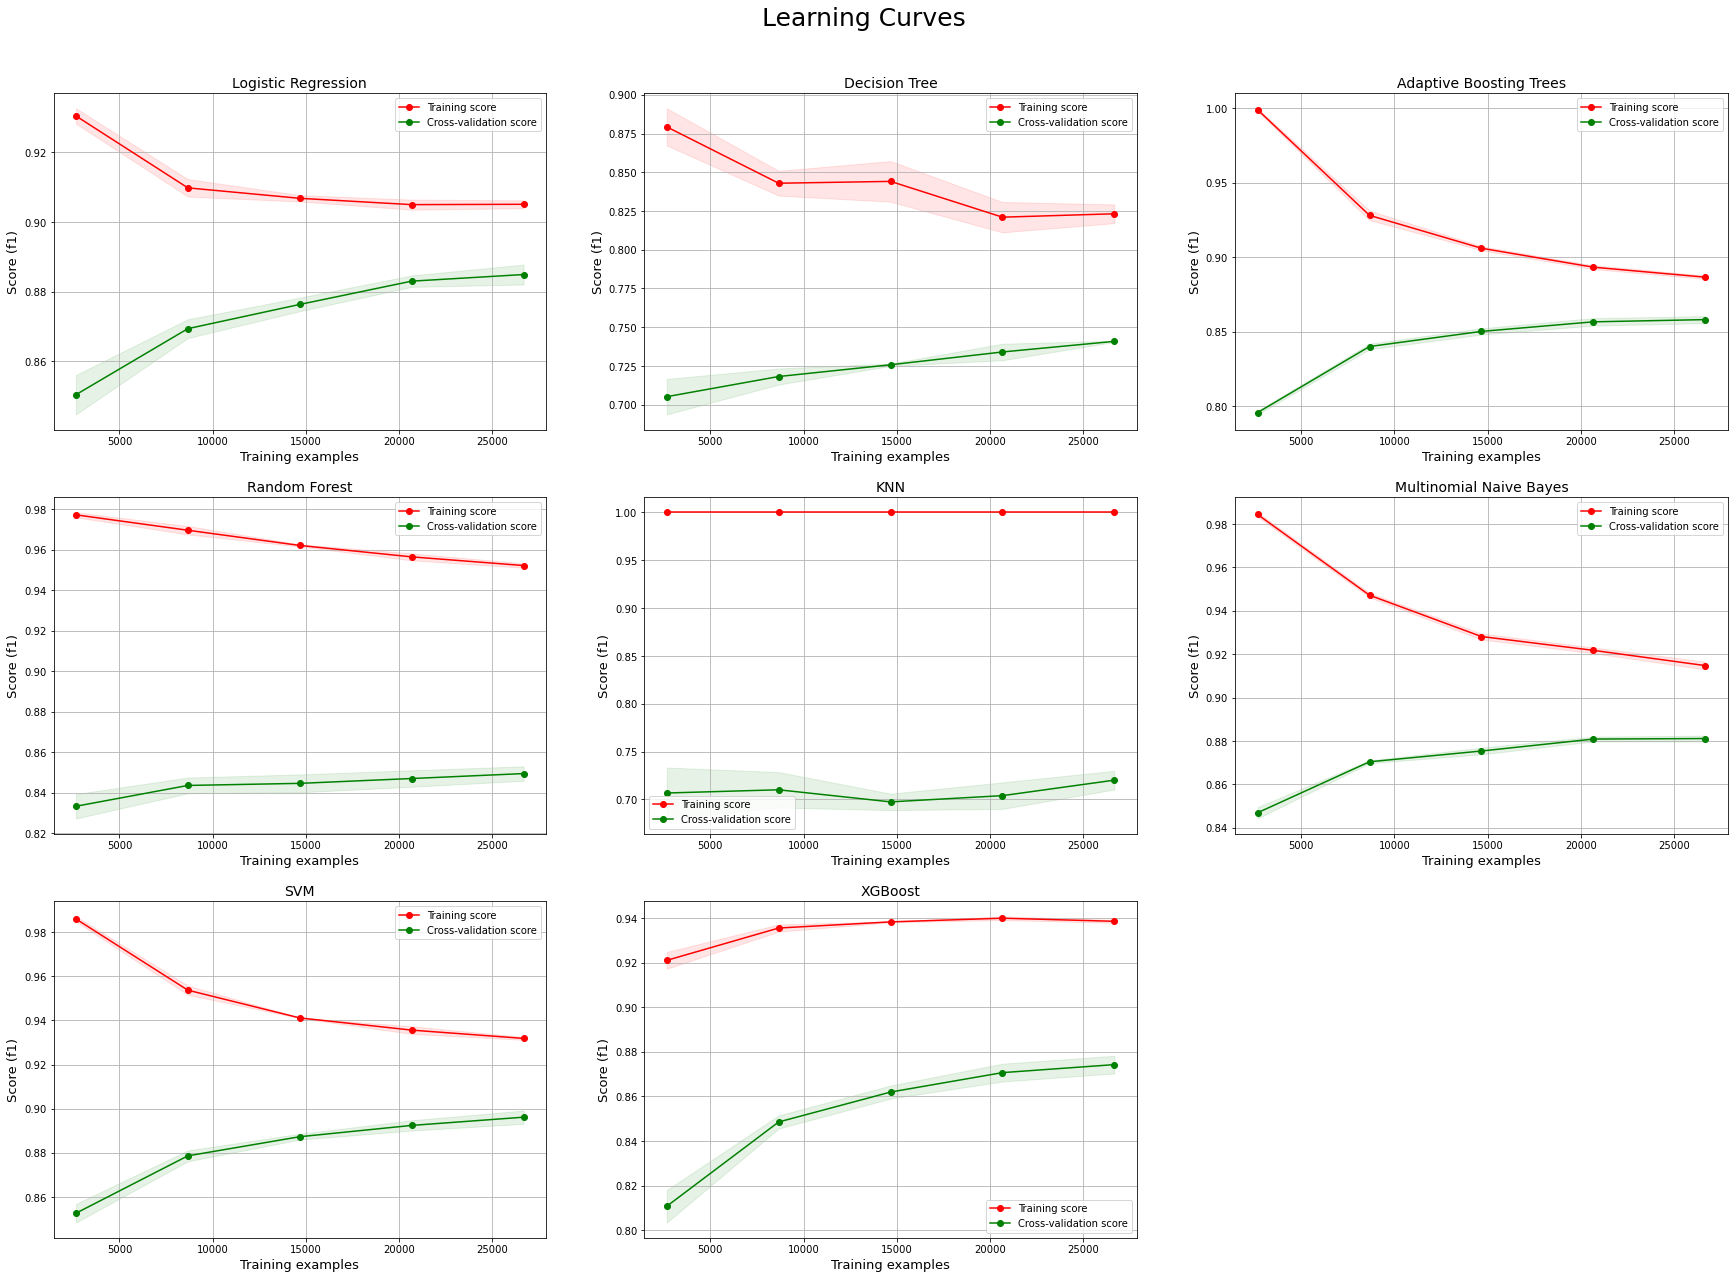

In [24]:
fig = plt.figure(figsize=(30,20))
fig.subplots_adjust(hspace=0.2)
fig.patch.set_alpha(1)
fig.suptitle('Learning Curves', fontsize=25)
fig.tight_layout()
fig.subplots_adjust(top=0.92)

for i, model in enumerate(total_models):
    ax = fig.add_subplot(3,3,i+1)
    ax.set_xlabel("Training examples", fontsize=13)
    ax.set_ylabel("Score (f1)", fontsize=13)
    ax.set_title(model[1], fontsize=14)

    train_sizes, train_scores, test_scores = learning_curve(model[0], X_train, y_train, cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5), scoring='f1_macro')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    ax.legend(loc="best")

#### Ensembling

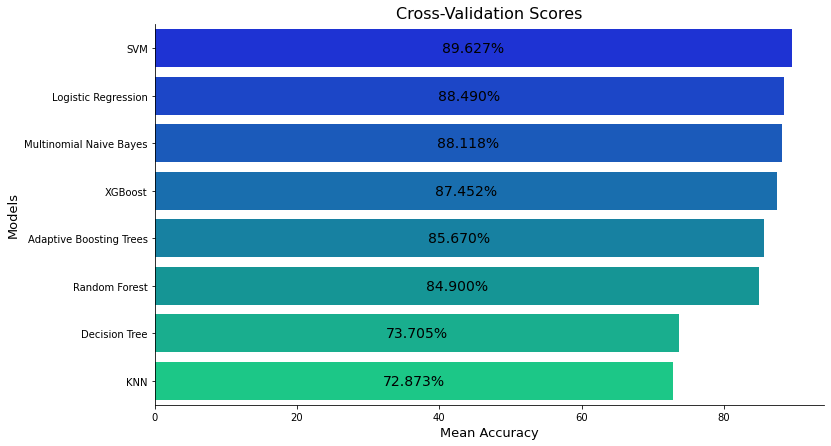

In [25]:
cv_accuracy = {
    'Logistic Regression': lr_scores['test_accuracy'].mean(),
    'Decision Tree': tree_scores['test_accuracy'].mean(),
    'Adaptive Boosting Trees': ada_scores['test_accuracy'].mean(),
    'Random Forest': forest_scores['test_accuracy'].mean(),
    'KNN': knn_scores['test_accuracy'].mean(),
    'Multinomial Naive Bayes': mnb_scores['test_accuracy'].mean(),
    'SVM': svm_scores['test_accuracy'].mean(),
    'XGBoost': xgb_scores['test_accuracy'].mean()
    }
cv_acc_df = pd.DataFrame(cv_accuracy.items()).rename(columns={0: 'Model', 1: 'Mean Accuracy'}).sort_values('Mean Accuracy', ascending=False)


fig = plt.figure(figsize=(12,7))
fig.patch.set_alpha(1)

g = sns.barplot(x=cv_acc_df['Mean Accuracy']*100, y=cv_acc_df['Model'], palette='winter')
g.set_title('Cross-Validation Scores', fontsize=16)
g.set_xlabel('Mean Accuracy', fontsize=13)
g.set_ylabel('Models', fontsize=13)
g.bar_label(g.containers[0], fmt='%.3f%%', fontsize=14, label_type='center')
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

In [26]:
ensemble = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('nb', m_nb),
        ('svm', svm),
        ('xgb', xgb)],
    voting='soft',
    n_jobs=4
)

In [27]:
ensemble.fit(X_train, y_train)
yhat = ensemble.predict(X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      5000
           1       0.90      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

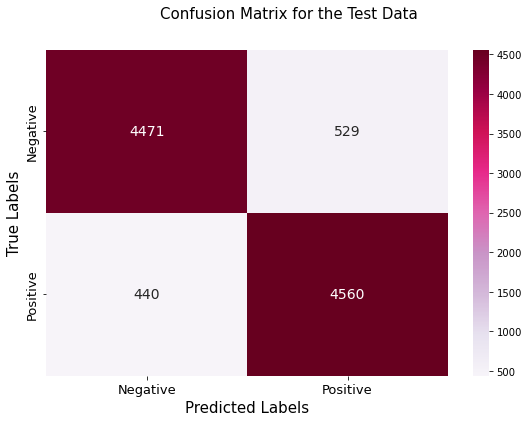

In [29]:
cm = confusion_matrix(y_test, yhat)

fig = plt.figure(figsize=(9,6))
fig.patch.set_alpha(1)
fig.suptitle('Confusion Matrix for the Test Data', fontsize=15)

g = sns.heatmap(cm, annot=True, fmt='g', cmap='PuRd', annot_kws={'size':14})

g.set_xlabel('Predicted Labels', fontsize=15)
g.set_ylabel('True Labels', fontsize=15)
g.xaxis.set_ticklabels(['Negative', 'Positive'], fontsize=13)
g.yaxis.set_ticklabels(['Negative', 'Positive'], fontsize=13)


In [30]:
y_probs = ensemble.predict_proba(X_test)

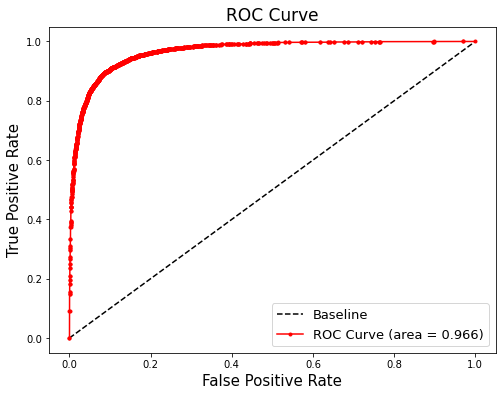

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])
auc_value = auc(fpr, tpr)

fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(1)

ax = fig.add_subplot(111)
ax.plot([0,1], [0,1], '--', color='k', label='Baseline')
ax.plot(fpr, tpr, marker='.', color='r', label=f"ROC Curve (area = {round(auc_value,3)})")
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_title("ROC Curve", fontsize=17)
ax.legend(loc='lower right', fontsize=13)